In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import sys
import os
import platform
import itertools

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

In [3]:
user_vimms = os.path.join("C:\\", "Users", "mcbrider5002", "Desktop", "Workspace", "phd", "peak_picking", "vimms")
#user_vimms = "vimms"
sys.path.append(user_vimms)

In [4]:
mzmine_path = os.path.join("C:\\", "Users", "mcbrider5002", "Desktop", "Workspace", "phd", "peak_picking", "MZmine-2.53-Windows", "startMZmine-Windows.bat")
#mzmine_path = os.path.join("MZmine-2.53-Windows", "startMZmine-Windows.bat")
old_mzmine = False
template_suffix = "_old" if old_mzmine else ""
mzmine_template = os.path.join(user_vimms, "batch_files", f"multi_sample_peak_pick{template_suffix}.xml")

xcms_r_script = os.path.join(user_vimms, "vimms", "scripts", "xcms_script.R")

In [5]:
from vimms.Common import (
    POSITIVE, load_obj,
    set_log_level_warning,
)
from vimms.PeakPicking import MZMineParams, XCMSScriptParams
from vimms.Experiment import Experiment
from vimms.BoxVisualise import (
    mpl_set_axis_style, mpl_set_figure_style,
    mpl_results_plot, plotly_results_plot,
    mpl_fragmentation_counts,
    plotly_timing_hist, seaborn_timing_hist,
    mpl_fragmentation_events, plotly_fragmentation_events,
    mpl_fragmented_boxes,
    seaborn_uncovered_area_hist,
    BoxViewer
)

 C:\Users\mcbrider5002\anaconda3\lib\site-packages\psims\mzmlb\writer.py:33: UserWarning:hdf5plugin is missing! Only the slower GZIP compression scheme will be available! Please install hdf5plugin to be able to use Blosc.


In [6]:
ionisation_mode = POSITIVE
pbar = False
set_log_level_warning()

1

In [7]:
data_dir = os.path.join("C:\\", "Users", "mcbrider5002", "Desktop", "Workspace", "phd", "data", "CLMS", "new_matching_seeds", "Negative")

In [8]:
num_workers = 8 #can't always use number of physical cores because of memory constraints

Utilities

In [9]:
def load_pkls(pickle_dir, case_names, repeat, load_rois=False):
    exp_pkls = {}
    for case_name in case_names:
        roi_str = "_rois" if load_rois else ""
        exp_pickle_paths = [f"{os.path.join(pickle_dir, case_name)}_{i}{roi_str}.pkl" for i in range(repeat)]
        exp_pkls[case_name] = [load_obj(pkl) for pkl in exp_pickle_paths]
    return exp_pkls

Specify line styles for mpl plots

In [10]:
mpl_colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colour_iterator = itertools.cycle(mpl_colours)
colour_map = { # have to do this manually...
    "topN" : mpl_colours[7],
    "topN_exclusion" : mpl_colours[1],
    "dsda" : mpl_colours[2],
    "dsda_resynced" : mpl_colours[2],
    "intensity_non_overlap_smartroi" : mpl_colours[3],
    "unweighted_matching" : mpl_colours[5],
    "two_step_matching" : mpl_colours[0],
    "two_step_matching_resynced" : mpl_colours[0],
    "two_step_matching_with_recursive_assignment" : mpl_colours[6],
    "two_step_matching_with_recursive_assignment_resynced" : mpl_colours[6],
    "two_step_matching_with_nearest_assignment" : mpl_colours[8],
    "topNEx_inclusion" : mpl_colours[1],
    "intensity_non_overlap_smartroi_inclusion" : mpl_colours[3]
}

def update_cmap(name):
    if(not name in colour_map):
        colour_map[name] = next(colour_iterator)
    return colour_map[name]

def get_style(name):
    if(name.lower().endswith("inclusion")):
        marker = "v"
    elif("resynced" in name):
        marker = "s"
    elif("matching" in name):
        marker = "^"
    else:
        marker = "o"
    
    c = update_cmap(name)
    return c, marker
    
def get_line_styles(case_names):
    colours, markers = [], []
    for case_name in case_names:
        c, m = get_style(case_name)
        colours.append(c)
        markers.append(m)
    return colours, markers

In [11]:
dda_name_map = {
    "topN" : "TopN",
    "topN_RoI" : "TopN RoI",
    "topN_exclusion" : "TopN Exclusion",
    "topNEx" : "TopNEx",
    "hard_roi_exclusion" : "Hard RoI Exclusion",
    "intensity_roi_exclusion" : "Intensity RoI Exclusion",
    "non_overlap" : "Non-Overlap",
    "intensity_non_overlap" : "INO"
}

matching_name_map = {
    "unweighted_matching" : "Unweighted Matching",
    "two_step_matching" : "TS Matching",
    "two_step_matching_with_recursive_assignment" : "TS Matching - R",
    "two_step_matching_with_nearest_assignment" : "TS Matching - N",
}

expanded_matching_name_map = {
    **matching_name_map,
    **{name + "_resynced": fname + "*" for name, fname in matching_name_map.items()}
}

#make smartroi/weighteddew versions of DDA
expanded_dda_name_map = {
    **dda_name_map,
    **{name + "_smartroi" : fname for name, fname in dda_name_map.items()},
    **{name + "_weighteddew" : fname for name, fname in dda_name_map.items()}
}

#make inclusion versions of all DDA incl. smartroi/weighteddew
inclusion_dda_name_map = {
    name + "_inclusion" : fname + " +" for name, fname in expanded_dda_name_map.items()
}

name_map = {
    "dsda" : "DsDA",
    "dsda_resynced" : "DsDA*",
    **expanded_dda_name_map,
    **inclusion_dda_name_map,
    **expanded_matching_name_map
}

markersize = 10

shared_legend = [
    Line2D([0], [0], marker="o", color="black", label="Baseline", markerfacecolor="black", markersize=markersize),
    Line2D([0], [0], marker="^", color="black", label="Matching", markerfacecolor="black", markersize=markersize),
    #Line2D([0], [0], marker="v", color="black", label="Inclusion Windows", markerfacecolor="black", markersize=markersize),
    Line2D([0], [0], marker="s", color="black", label="Matching Resynced", markerfacecolor="black", markersize=markersize),
]

def get_legend_items(case_names):
    case_legend = []
    for name in case_names:
        c, m = get_style(name)
        case_legend.append(
            Line2D([0], [0], marker=m, color=c, label=name_map[name], markersize=markersize)
        )

    return case_legend

In [12]:
fig_kwargs = {
    "tick_kwargs" : {
        "width" : 2.5,
        "length" : 12,
        "labelsize" : 22,
    },
    
    "axis_borderwidth" : 2.5,
    
    "axis_kwargs" : {
        "labelsize" : 24,
        "titlesize" : 24,
        "linewidth" : 1.5,
        "markersize" : 6,
        "legend_kwargs" : {
            "fontsize" : 13
        }
    },
    
    "suptitle" : "Default Suptitle",
    "suptitle_size" : 18,
    "figure_sizes" : (18, 8),
}

In [13]:
'''
centwave_params = {
    "ppm" : 10,
    "pwlower" : 20,
    "pwupper" : 80,
    "snthresh" : 10,
    "noise" : 0,
    "prefilterlower" : 3,
    "prefilterupper" : 30
}
'''

centwave_params = {
    "ppm" : 15,
    "pwlower" : 15,
    "pwupper" : 80,
    "snthresh" : 5,
    "noise" : 1000,
    "prefilterlower" : 3,
    "prefilterupper" : 500
}

mzmine_object = MZMineParams(
    mzmine_template = mzmine_template,
    mzmine_exe = mzmine_path
)

xcms_object = XCMSScriptParams(
    xcms_r_script = xcms_r_script,
    **centwave_params,
    mzvsrtbalance = None,
    absmz = None,
    absrt = None,
    kNN = None
)

#pp_params = mzmine_object
pp_params = xcms_object

# 1. Same Beer Repeated Multiple Times

### Evaluate

In [14]:
repeat = 4

same_case_names = [
    "topN",
    "topN_exclusion",
    "intensity_non_overlap_smartroi",
    "dsda",
    "dsda_resynced",
    "two_step_matching",
    "two_step_matching_resynced",
    "two_step_matching_with_recursive_assignment",
    "two_step_matching_with_recursive_assignment_resynced"
]

line_colours, line_markers = get_line_styles(same_case_names)
legend_elements = get_legend_items(same_case_names)

In [15]:
isolation_width = 1.0
desync_factors = [1 + i / 10 for i in range(-5, 6)]
out_dirs = [f"new_same_beer_desync{int(100 * (df))}" for df in desync_factors]

same_beer_exps = []
for out_dir in out_dirs:
    same_beer_exp = Experiment.load_from_json(
        file_dir = out_dir,
        file_name = "keyfile.json",
        out_dir = out_dir,
        fullscan_dir = data_dir,
        amend_result_path = True,
        case_names = same_case_names
    )
    
    true_repeat = min(
        repeat,
        len(same_beer_exp.case_mzmls[same_beer_exp.case_names[0]])
    )
    
    same_beer_exp.evaluate(
        pp_params = pp_params,
        num_workers = num_workers,
        isolation_widths = isolation_width,
        max_repeat = repeat,
        aligned_names = f"stefanbeersID1" + template_suffix,
        force_peak_picking = False
    )

    same_beer_exps.append(same_beer_exp)

5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file

5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file

5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file
5979 aligned boxes contained in file

### Plot

topN
Number of chems above min intensity: 5120
Number of fragmentations: [13006, 13006, 13006, 13006]
Cumulative coverage: [3395, 3395, 3395, 3395]
Cumulative coverage proportion: [0.6630859375, 0.6630859375, 0.6630859375, 0.6630859375]
Cumulative intensity proportion: [0.43273107871759475, 0.43273107871759475, 0.43273107871759475, 0.43273107871759475]
Cumulative intensity proportion of covered spectra: [0.6526018035446495, 0.6526018035446495, 0.6526018035446495, 0.6526018035446495]
Times covered: {0: 2584, 4: 3395}
Times fragmented: {0: 2291, 4: 1883, 8: 880, 12: 437, 16: 182, 20: 92, 24: 51, 28: 24, 32: 22, 36: 4, 40: 10, 44: 6, 48: 7, 52: 1, 56: 7, 60: 5, 64: 10, 68: 6, 72: 9, 76: 4, 80: 1, 84: 2, 88: 9, 92: 4, 96: 9, 100: 3, 104: 10, 108: 1, 112: 1, 120: 8}

topN_exclusion
Number of chems above min intensity: 5648
Number of fragmentations: [13006, 9656, 4622, 2244]
Cumulative coverage: [3395, 4046, 4172, 4223]
Cumulative coverage proportion: [0.6010977337110481, 0.7163597733711048,

topN
Number of chems above min intensity: 13450
Number of fragmentations: [4281, 4281]
Cumulative coverage: [3641, 3641]
Cumulative coverage proportion: [0.2707063197026022, 0.2707063197026022]
Cumulative intensity proportion: [0.19856091871478831, 0.19856091871478831]
Cumulative intensity proportion of covered spectra: [0.762559002029356, 0.762559002029356]
Times covered: {0: 10342, 2: 3641}
Times fragmented: {0: 9813, 2: 3183, 4: 663, 6: 174, 8: 29, 10: 11, 12: 7, 14: 1, 16: 18, 18: 17, 20: 10, 22: 2, 24: 2, 26: 1, 28: 1, 30: 27, 32: 5, 34: 7, 36: 11, 38: 1}

intensity_non_overlap_weighteddew
Number of chems above min intensity: 13607
Number of fragmentations: [4277, 4306]
Cumulative coverage: [3598, 5487]
Cumulative coverage proportion: [0.264422723598148, 0.4032483280664364]
Cumulative intensity proportion: [0.18935275751246688, 0.3203600427653424]
Cumulative intensity proportion of covered spectra: [0.7358864948017856, 0.8164013993052274]
Times covered: {0: 8496, 1: 3609, 2: 1878}

topN
Number of chems above min intensity: 13450
Number of fragmentations: [4281, 4281]
Cumulative coverage: [3641, 3641]
Cumulative coverage proportion: [0.2707063197026022, 0.2707063197026022]
Cumulative intensity proportion: [0.19856091871478831, 0.19856091871478831]
Cumulative intensity proportion of covered spectra: [0.762559002029356, 0.762559002029356]
Times covered: {0: 10342, 2: 3641}
Times fragmented: {0: 9813, 2: 3183, 4: 663, 6: 174, 8: 29, 10: 11, 12: 7, 14: 1, 16: 18, 18: 17, 20: 10, 22: 2, 24: 2, 26: 1, 28: 1, 30: 27, 32: 5, 34: 7, 36: 11, 38: 1}

intensity_non_overlap_weighteddew
Number of chems above min intensity: 13607
Number of fragmentations: [4277, 4306]
Cumulative coverage: [3598, 5487]
Cumulative coverage proportion: [0.264422723598148, 0.4032483280664364]
Cumulative intensity proportion: [0.18935275751246688, 0.3203600427653424]
Cumulative intensity proportion of covered spectra: [0.7358864948017856, 0.8164013993052274]
Times covered: {0: 8496, 1: 3609, 2: 1878}

topN
Number of chems above min intensity: 13450
Number of fragmentations: [4281, 4281]
Cumulative coverage: [3641, 3641]
Cumulative coverage proportion: [0.2707063197026022, 0.2707063197026022]
Cumulative intensity proportion: [0.19856091871478831, 0.19856091871478831]
Cumulative intensity proportion of covered spectra: [0.762559002029356, 0.762559002029356]
Times covered: {0: 10342, 2: 3641}
Times fragmented: {0: 9813, 2: 3183, 4: 663, 6: 174, 8: 29, 10: 11, 12: 7, 14: 1, 16: 18, 18: 17, 20: 10, 22: 2, 24: 2, 26: 1, 28: 1, 30: 27, 32: 5, 34: 7, 36: 11, 38: 1}

intensity_non_overlap_weighteddew
Number of chems above min intensity: 13607
Number of fragmentations: [4277, 4306]
Cumulative coverage: [3598, 5487]
Cumulative coverage proportion: [0.264422723598148, 0.4032483280664364]
Cumulative intensity proportion: [0.18935275751246688, 0.3203600427653424]
Cumulative intensity proportion of covered spectra: [0.7358864948017856, 0.8164013993052274]
Times covered: {0: 8496, 1: 3609, 2: 1878}

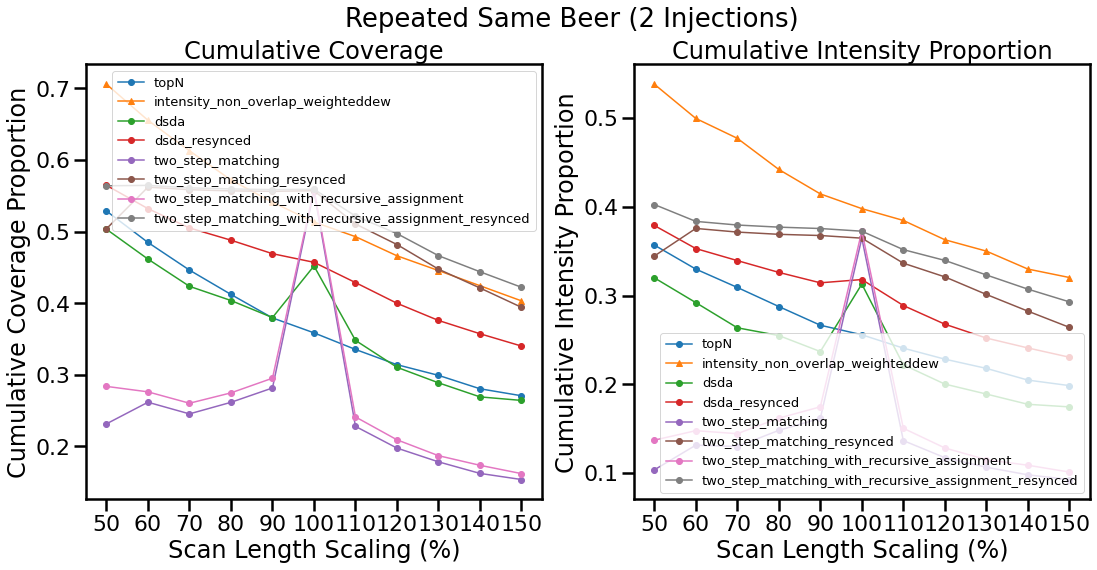

In [16]:
same_cases = {name : [] for name in same_case_names}
for exp in same_beer_exps:
    for name, report in exp.get_reports(min_intensities=5000.0, num_workers=num_workers).items():
    #for name, report in exp.get_reports(min_intensities=None, num_workers=num_workers).items():
        same_cases[name].append(report)
    exp.summarise(num_workers=num_workers, min_intensities=5000)

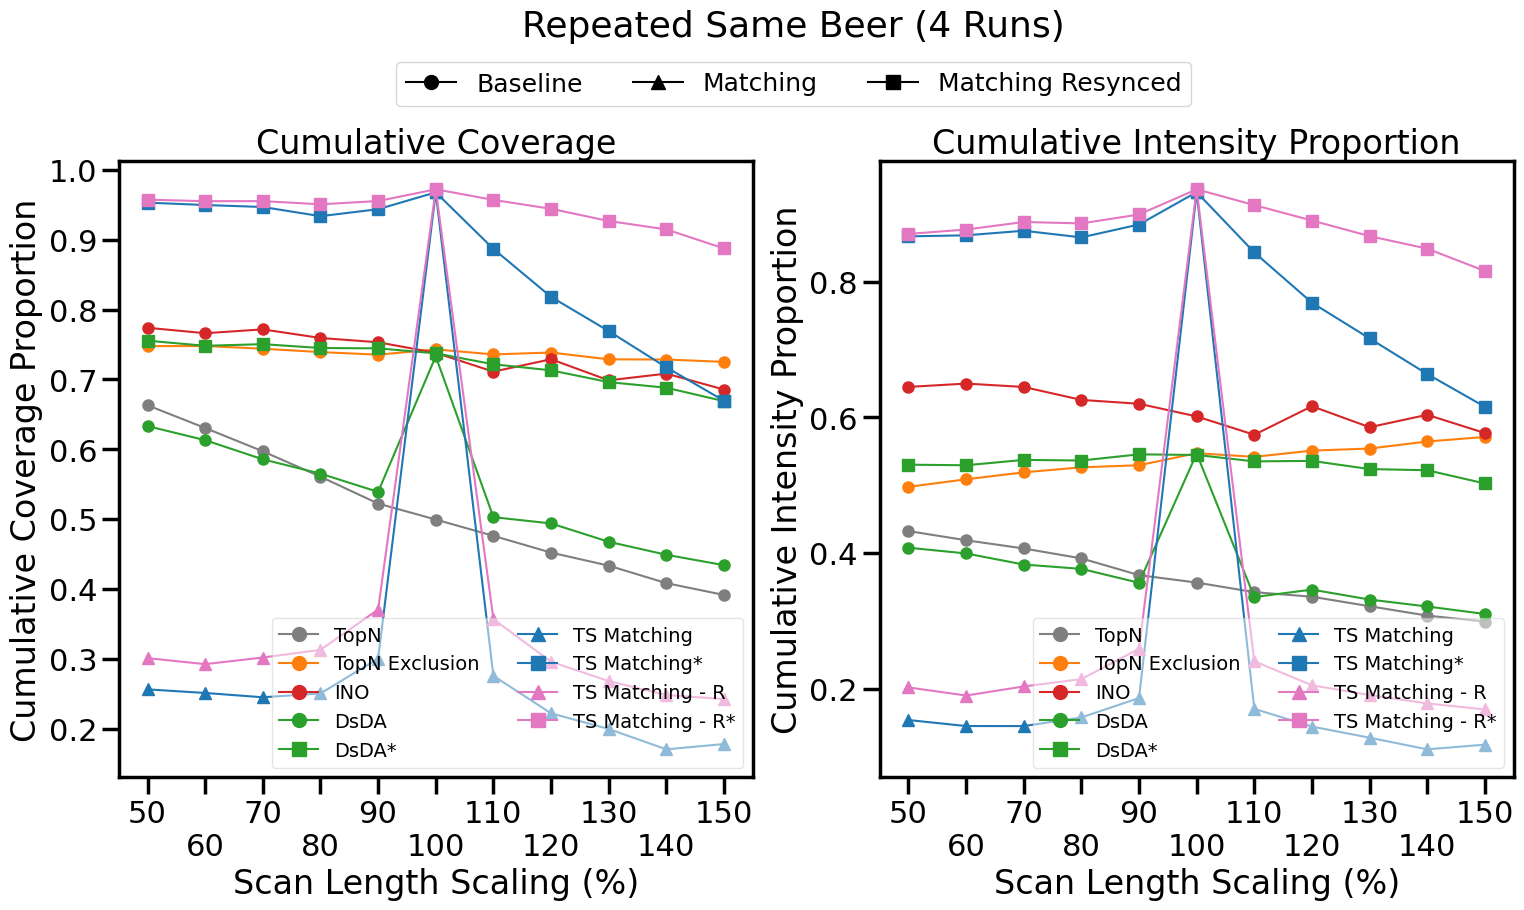

In [17]:
layouts = {
    "cumulative_coverage_proportion" : {
        "title" : "Cumulative Coverage",
        "ylabel" :  f"Cumulative Coverage Proportion",
    },

    "cumulative_intensity_proportion" : {
        "title" : "Cumulative Intensity Proportion",
        "ylabel" : f"Cumulative Intensity Proportion",
    }
}

fig, axes = plt.subplots(1, 2)
xs = range(len(same_beer_exps))
keys = ["cumulative_coverage_proportion", "cumulative_intensity_proportion"]

for ax, k in zip(axes, keys):
    for exp_name, c, m in zip(same_case_names, line_colours, line_markers):
        ys = [report[k][-1] for report in same_cases[exp_name]]
        ax.plot(xs, ys, label=exp_name, color=c, marker=m)
        ax.set(
            xlabel="Scan Length Scaling (%)",
            xticks=xs,
            xticklabels=[('\n' if (i % 2 == 1) else '') + f"{int(df * 100)}" for i, df in enumerate(desync_factors)],
            **layouts[k]
        )
        ax.legend()

kwargs = {
    **fig_kwargs,
    "axis_kwargs" : {
        **fig_kwargs["axis_kwargs"],
        "markersize" : 8,
        "legend_kwargs" : {
            **fig_kwargs["axis_kwargs"]["legend_kwargs"], 
            "fontsize" : 14,
            "facecolor" : (1, 1, 1, 0.2),
            "framealpha" : 0.5,
            "ncol" : 2,
            "loc" : "lower right",
            "handles" : legend_elements,
            "alignment" : "right"
        },
    },
    #"suptitle" : f"Repeated Same Beer ({repeat} Injections)", "suptitle_size" : 26
}
        
#mpl_set_figure_style(fig, **{**fig_kwargs, "suptitle" : f"Repeated Same Beer ({repeat} Injections)", "suptitle_size" : 26})
#mpl_set_axis_style(axes[1], legend_kwargs={**fig_kwargs["axis_kwargs"]["legend_kwargs"], "loc" : "lower right"})

mpl_set_figure_style(fig, **kwargs)
plt.suptitle(f"Repeated Same Beer ({repeat} Runs)", size=26, y=1.07)
fig.legend(fontsize = 18, handles=shared_legend, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3)
os.makedirs(os.path.join("..", "paper", "plots"), exist_ok=True)
fig.savefig(os.path.join("..", "paper", "plots", f"resync_same_beer_{pp_params.method_name}.pdf"), format="pdf", bbox_inches="tight")